In [1]:
import matplotlib.pyplot as plt 
import pandas as pd
from sqlalchemy import create_engine
import seaborn as sns
import jinja2
import re
import datetime
import numpy as np



#1) importation des identifiants pour sql
file_s="//home//pw//Documents//cours_simplon//exercice_simplon//exercice_jinja//configuration_sql"
list_config=''
pattern=r'.+:|\n'
with open(file_s,'r') as file_s:
    list_config=[re.sub(pattern,'',i) for i in file_s.read().split(',\n')] # lecture d'un fichier pour l'accès aux identifiants de connexion aux serveurs

engine="mysql+pymysql://{0}:{1}@{2}:{3}/{4}".format(list_config[0],list_config[1],list_config[2],list_config[3],list_config[4]) # utilsiation des identifiants sous forme d'une liste.
engine=create_engine(engine)

In [2]:
#2) importaion du template

tmpl_dir="//home//pw//Documents//cours_simplon//exercice_simplon//exercice_jinja"
tmpl="//rapport.jinja"

TemplateLoader=jinja2.FileSystemLoader(searchpath=tmpl_dir)
TemplateEnv=jinja2.Environment(loader=TemplateLoader)
Template=TemplateEnv.get_template(tmpl)

In [3]:
#3) paramétrage du requêtage sur SQL


#param=[i for i in input('entrez vos paramètres de recherche selon le format suivant:\n "colonne cible, colonne critère, valeur de la critère, taille de l'échantillon sous forme de chaîne de caractères \n:').split(', ')]
param=['categorie', 'pays', "India", 20]
print("parameters done")

query=f'SELECT DISTINCT {param[1]}_.name as name1, {param[0]}_.name, {param[0]}_.title, {param[0]}_.rating, {param[0]}_.duration, {param[0]}_.release_year, {param[0]}_.type FROM {param[1]}_ '  
query+=f'INNER JOIN {param[0]}_ ON {param[1]}_.show_id={param[0]}_.show_id '
query+=f'INNER JOIN (SELECT DISTINCT {param[0]}_.name FROM {param[0]}_ '
query+=f'INNER JOIN {param[1]}_ ON {param[0]}_.show_id={param[1]}_.show_id '
query+=f'GROUP BY {param[0]}_.name ORDER BY COUNT({param[1]}_.title) DESC limit {param[3]}) as s_r '
query+=f'ON {param[0]}_.name=s_r.name;'



""" exemple de requếte avec la VD :'catégorie' et la VI:'pays': 
    
SELECT pays_.name, categorie_.name, categorie_.title, categorie_.type, categorie_.rating, categorie_.duration, categorie_.release_year FROM categorie_ 
INNER JOIN pays_ on categorie_.title=pays_.title
INNER JOIN (SELECT distinct categorie_.name FROM categorie_ 
INNER JOIN pays_ ON pays_.show_id=categorie_.show_id 
GROUP BY categorie_.name 
ORDER BY COUNT(pays_.title) DESC limit 60) as s_r ON categorie_.name=s_r.name ;"""

parameters done


" exemple de requếte avec la VD :'catégorie' et la VI:'pays': \n    \nSELECT pays_.name, categorie_.name, categorie_.title, categorie_.type, categorie_.rating, categorie_.duration, categorie_.release_year FROM categorie_ \nINNER JOIN pays_ on categorie_.title=pays_.title\nINNER JOIN (SELECT distinct categorie_.name FROM categorie_ \nINNER JOIN pays_ ON pays_.show_id=categorie_.show_id \nGROUP BY categorie_.name \nORDER BY COUNT(pays_.title) DESC limit 60) as s_r ON categorie_.name=s_r.name ;"

In [4]:
#4) ableau1: recherche élargie

tableau=pd.read_sql_query(query, engine)
tabelau=tableau.rename(columns={'name1':'name_VI', 'name':'name_VD'}, inplace=True) 

 # renommage des colonnes pour éviter des confusions entre les 2 intitulés initailes des colonnes "names"
liste=tableau[['name_VI','name_VD']].groupby(by=['name_VI']).count().sort_values(by='name_VD', ascending=False).index# tri des modalités de VI les plus  impactans
tableau_temp=tableau[tableau['name_VI'].isin(liste[0:10])]      #création d'un dataframme des lignes du tableau à la condition que la valeur ['name_VI'] de a ligne soit compris dans la liste
tableau_temp=tableau_temp[['name_VD', 'name_VI', 'title']].groupby(by=['name_VI', 'name_VD']).count().reset_index(level=1).pivot(columns='name_VD')# comptage des apparitions de chaque couple de paramètres VD et VI, avec réorganisation du dataframme
# pour mettre les modalités de la VD en index et les modalités de la VI en colonnes 

tableau_temp.columns=tableau_temp.columns.droplevel(0) # commande utilisé pour supprimer le mutli-indexing au level 0 ("name_VD") opérant suite à la commande'pivot'
print("data importation executed" )
tableau_temp

data importation executed


name_VD,Adventure,British TV Shows,Children & Family Movies,Comedies,Crime TV Shows,Documentaries,Docuseries,Dramas,Horror Movies,Independent Movies,International Movies,International TV Shows,Kids' TV,Music & Musicals,Romantic Movies,Sci-Fi & Fantasy,Stand-Up Comedy,TV Comedies,TV Dramas,Thrillers
name_VI,,,,,,,,,,,,,,,,,,,,
Canada,29.0,3.0,43.0,68.0,14.0,31.0,10.0,56.0,22.0,32.0,44.0,23.0,50.0,9.0,16.0,16.0,2.0,27.0,27.0,31.0
China,47.0,1.0,9.0,23.0,4.0,5.0,1.0,26.0,1.0,1.0,59.0,31.0,4.0,1.0,9.0,11.0,NaN,9.0,18.0,4.0
France,18.0,1.0,15.0,37.0,18.0,25.0,6.0,114.0,9.0,50.0,148.0,35.0,32.0,3.0,18.0,8.0,4.0,17.0,23.0,23.0
Germany,23.0,5.0,12.0,30.0,11.0,17.0,5.0,58.0,4.0,23.0,67.0,17.0,5.0,6.0,7.0,10.0,2.0,2.0,10.0,15.0
India,125.0,NaN,15.0,246.0,7.0,25.0,5.0,538.0,31.0,128.0,718.0,48.0,5.0,92.0,91.0,11.0,1.0,15.0,21.0,72.0
Japan,39.0,NaN,9.0,6.0,12.0,6.0,NaN,10.0,3.0,5.0,44.0,111.0,27.0,3.0,4.0,8.0,NaN,9.0,20.0,3.0
South Korea,15.0,NaN,5.0,10.0,16.0,2.0,NaN,24.0,3.0,2.0,34.0,97.0,16.0,1.0,1.0,4.0,2.0,7.0,17.0,11.0
Spain,5.0,3.0,6.0,40.0,20.0,16.0,6.0,63.0,9.0,17.0,111.0,40.0,3.0,4.0,9.0,8.0,NaN,5.0,9.0,28.0
United Kingdom,59.0,192.0,24.0,67.0,43.0,105.0,82.0,122.0,22.0,52.0,125.0,106.0,21.0,23.0,23.0,28.0,17.0,38.0,27.0,43.0


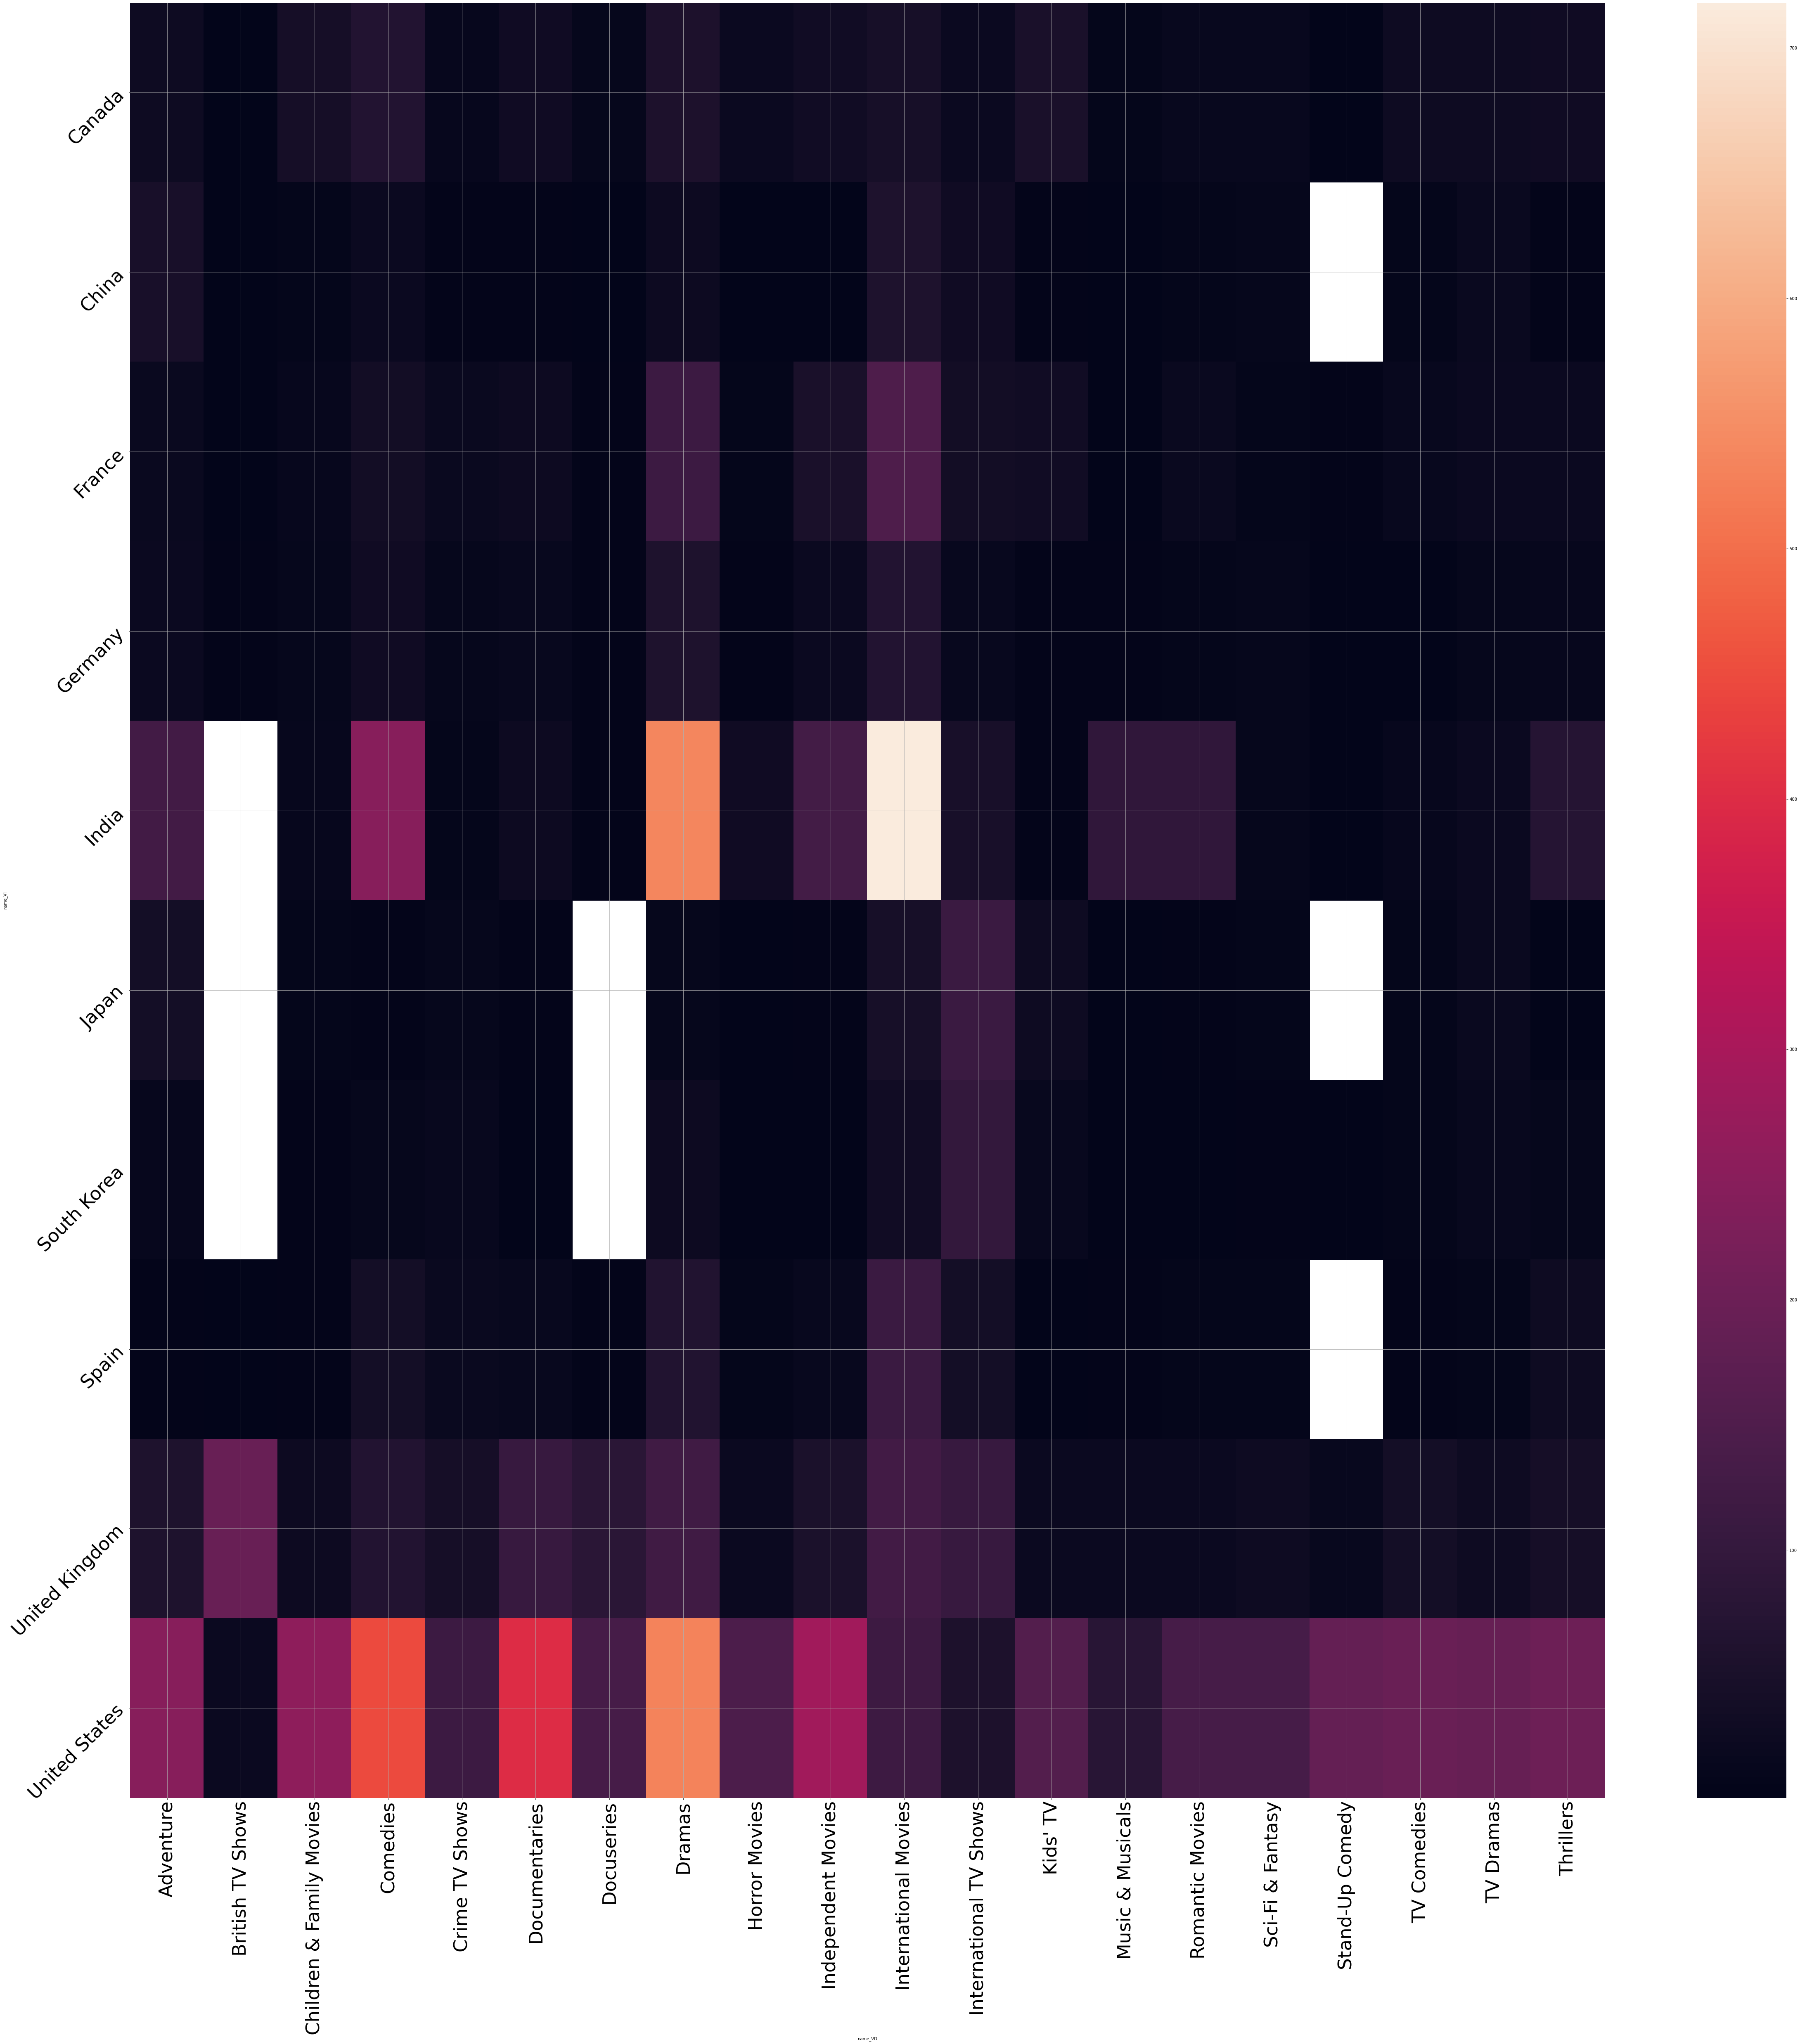

first diagram executed


In [5]:
#5) premier graphique: tableau de contingence entre les modalités de la VI et de la VD


plt.figure(figsize=[80,80])
ax1=sns.heatmap( tableau_temp )
ax1.set_xticklabels(fontsize=45, labels=tableau_temp.columns, rotation=90) # paramétrage des vignettes des modalités de la VD
ax1.set_yticklabels(fontsize=45 ,labels=tableau_temp.index, rotation=45) # paramétrage des vignettes des modalités de la VI
plt.grid()
plt.savefig('//home//pw//Documents//cours_simplon//exercice_simplon//exercice_jinja//graph1.png')
plt.show()
print("first diagram executed" )

second diagram executed


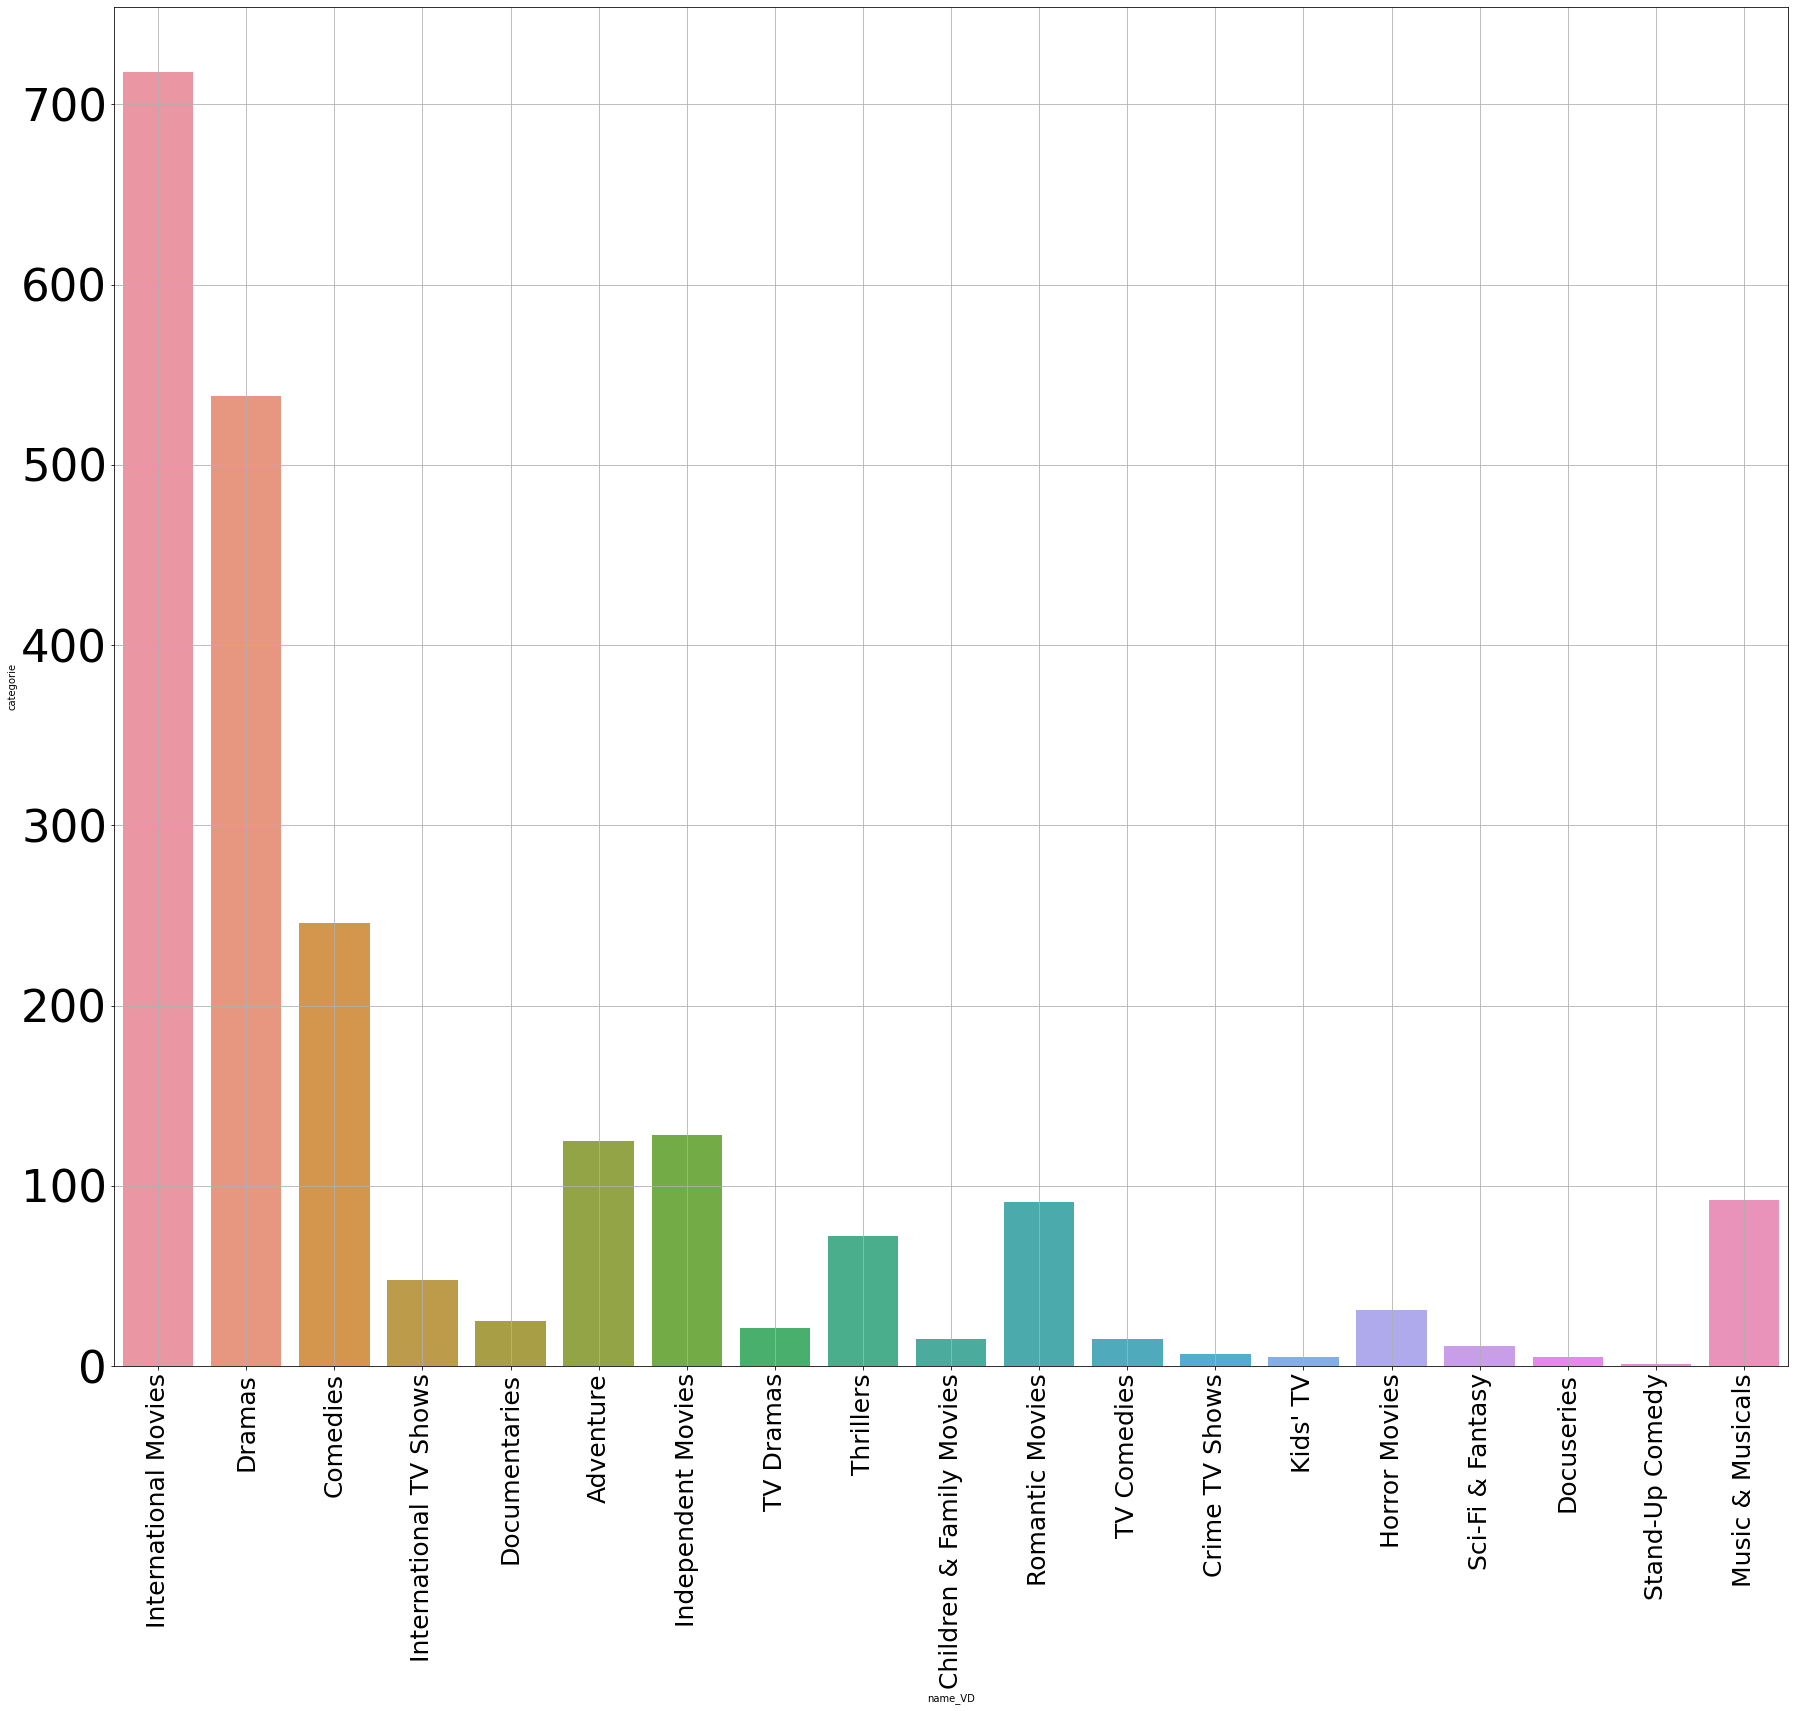

In [6]:
#6) deuxième tableau: diagramme de comptage des modalités 


film_info=tableau[tableau['name_VI']==param[2]] # création d'un dataframme temporaire regroupant toutes les lignes de "tableau" ,contenant la modalité entrée 'param[2] de la VI.

dic={'nom':param[2], 'nb_sujet':param[3] ,'time_stamp':datetime.datetime.now().strftime("%x %X"), 'variable_VD': param[0], 'variable_VI': param[1]}
plt.figure(figsize=[30,25])
ax1=sns.countplot(x='name_VD', data=film_info, orient='v')  #création du diagramme 
ax1.set_xticklabels(labels=film_info['name_VD'].unique(), fontsize=25, rotation=90) 
plt.yticks(fontsize=45)
ax1.set_ylabel(f'{param[0]}')
plt.grid()
plt.savefig("//home//pw//Documents//cours_simplon//exercice_simplon//exercice_jinja//graph2.png")

print('second diagram executed')

<ipython-input-7-93e0c68fad28>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  film_info['release_year']=pd.cut(film_info['release_year'],4) # découpage en 4 périodes d'années équivalentes
<ipython-input-7-93e0c68fad28>:26: MatplotlibDeprecationWarning: Unrecognized location 'center-left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  plt.legend(labels=labels, loc='center-left', bbox_to_anchor=(1.5, 0.9), fontsize=12)


third diagram executed


<Figure size 1080x1080 with 0 Axes>

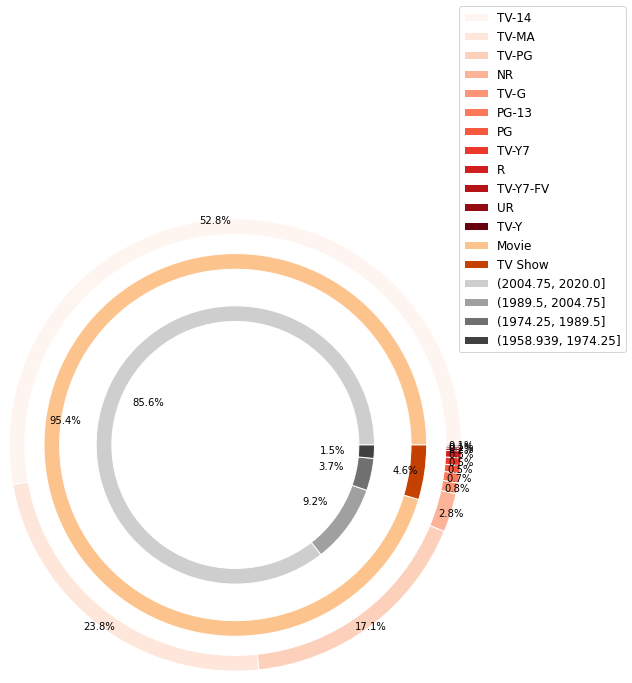

In [7]:
#7) troisième tableau: camembert des tendances de profils des films produits


film_info['release_year']=pd.cut(film_info['release_year'],4) # découpage en 4 périodes d'années équivalentes

size=0.4
labels=list(film_info['rating'].value_counts().index)
labels+=list(film_info['type'].value_counts().index )
labels+=list(film_info['release_year'].value_counts().index) # création d'une liste regroupant dans l'ordre tous les labels des colonnes représentées sur le camembert


plt.figure(figsize=[15,15])
fig, ax1=plt.subplots() 
cmap1=plt.cm.Reds #attribution des couleurs pour le camembert extérieur
cmap2=plt.cm.Oranges #attribution des couleurs pour le camembert intermédiaire
cmap3=plt.cm.Greys #attribution des couleurs pour le camembert intérieur
colors1=cmap1(np.linspace(0, 1, len(list (film_info['rating'].value_counts().values      )))) 
colors2=cmap2(np.linspace(0.30, 0.80 , len(list (film_info['type'].value_counts().values       ))))
colors3=cmap3(np.linspace(0.3, 0.80 ,len(list( film_info['release_year'].value_counts().values    ))))


ax1.pie (film_info['rating'].value_counts().values,autopct='%1.1f%%',colors=colors1 , radius=2.6, wedgeprops=dict(width=0.18 , edgecolor='w'), pctdistance = 1.0)
ax1.pie(film_info['type'].value_counts().values, autopct='%1.1f%%', colors=colors2 ,radius=2.6-size,  wedgeprops=dict(width=0.18, edgecolor='w') ,labeldistance=0.8, pctdistance = 0.9)
ax1.pie(film_info['release_year'].value_counts().values, autopct='%1.1f%%', colors=colors3, radius=2.6-(size*2.5), wedgeprops=dict(width=0.18 , edgecolor='w'), labeldistance=0.2, pctdistance=0.70 )
ax1.tick_params(axis='y', which='major', pad=40)
plt.legend(labels=labels, loc='center-left', bbox_to_anchor=(1.5, 0.9), fontsize=12)
plt.savefig('//home//pw//Documents//cours_simplon//exercice_simplon//exercice_jinja//graph3') ##remarque: le fichier enregistré automatiquement n'est pas au bon zoom. il vaut mieux l'enregistrer manuellement.
print('third diagram executed')

In [8]:
#8) exportation du template


outputtext=Template.render(dic)
with open('//home/pw/Documents/cours_simplon/exercice_simplon/exercice_jinja/template_transit/index.html','w') as file: ## le template en résultant sera stockée dans le dossier "template_transit" , ce afin que les scripts html et css puissent s'éxecuter
    file.write(outputtext)
    print('template exportation executed')
print('executed script')

template exportation executed
executed script
